# gbdt

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [2]:
# データ準備
df = sns.load_dataset('titanic')

# 欠損値削除
df.dropna(inplace=True)

# X,y生成
X = df.loc[:, (df.columns!='survived') & (df.columns!='alive')]
y = df['survived']

# ラベルエンコーディング
# .set_output(transform='pandas')：　oeがnumpyで返るのをpandasにする
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
oe.set_output(transform='pandas')
X[cat_cols] = oe.fit_transform(X[cat_cols])

# 学習/テストデータ分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

/tmp/ipykernel_258/1260895635.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = oe.fit_transform(X[cat_cols])


## XGBoost

XGBoost
- xgboostのパッケージをインストール
    - pip install xgboost
- xgboost.XGBClassifierクラス
    - n_estimators: イテレーションの回数（弱学習器の数)
    - learning_rate: 学習率のパラメータη
    - eval_metric: early stoppingに使用する評価指標(sklearn.metricsのメソッドを指定)
    - early_stopping_rounds: early stoppingする際の最低限のイテレーション回数
    - importance_type: デフォルトだと"weight"(頻度)になっているので"total_gain"する
    - early stoppingについて
        - boostingのイテレーションをする際、これ以上残差が下がらなくなったら学習をstopする残差の閾値
        - それにより、過学習を抑制することができる
- .fit(X,y)で学習
    - eval_set: 各イテレーションごとに評価したいデータ　　
        - 例: [(X_val, y_val)]
    - verbose: Trueを指定すると各イテレーションの評価結果をprintする
- predict(X)で予測
- xgboost.plot_tree(model, num_trees)で任意の木構造を描画
    - graphizを事前にインストールする(apt-get install graphizおよび、pip install graphiz)

In [3]:
# !pip install xgboost

In [4]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.01, 
                    eval_metric='auc', 
                    early_stopping_round=10,
                    importance_type='total_gain',
                    random_state=0)
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

[00:33:04] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[0]	validation_0-auc:0.89904
[1]	validation_0-auc:0.89663
[2]	validation_0-auc:0.89663
[3]	validation_0-auc:0.89663
[4]	validation_0-auc:0.89663
[5]	validation_0-auc:0.89663
[6]	validation_0-auc:0.89103
[7]	validation_0-auc:0.89103
[8]	validation_0-auc:0.88942
[9]	validation_0-auc:0.89103
[10]	validation_0-auc:0.88622
[11]	validation_0-auc:0.88622
[12]	validation_0-auc:0.88622
[13]	validation_0-auc:0.88942
[14]	validation_0-auc:0.88622
[15]	validation_0-auc:0.88942
[16]	validation_0-auc:0.88622
[17]	validation_0-auc:0.88462
[18]	validation_0-auc:0.88782
[19]	validation_0-auc:0.88462
[20]	validation_0-auc:0.87981
[21]	validation_0-auc:0.88462
[22]	validation_0-auc:0.88141
[23]	validation_0-auc:0.88462
[24]	validation_0-auc:0.88141
[25]	validation_0-auc:0.88301
[26]	validation_0-auc:0.88141
[27]	validation_0-auc:0.88301
[28]	validation_0-auc:0.88462
[29]	validation_0-auc:0.88301
[30]	validat

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_round=10,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type='total_gain',
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [5]:
from sklearn.metrics import roc_auc_score
y_pred_xgb = xgb.predict_proba(X_test)
print(f'xgboost AUC: {roc_auc_score(y_test, y_pred_xgb[:, 1])}')

xgboost AUC: 0.8806089743589745


In [6]:
# xgbの重要度
xgb.feature_importances_

array([0.        , 0.        , 0.2102564 , 0.        , 0.        ,
       0.17574202, 0.        , 0.        , 0.02156972, 0.5117985 ,
       0.0625558 , 0.        , 0.0180776 ], dtype=float32)

In [7]:
# xgbの特徴量の名前
xgb.feature_names_in_

array(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked',
       'class', 'who', 'adult_male', 'deck', 'embark_town', 'alone'],
      dtype='<U11')

<BarContainer object of 13 artists>

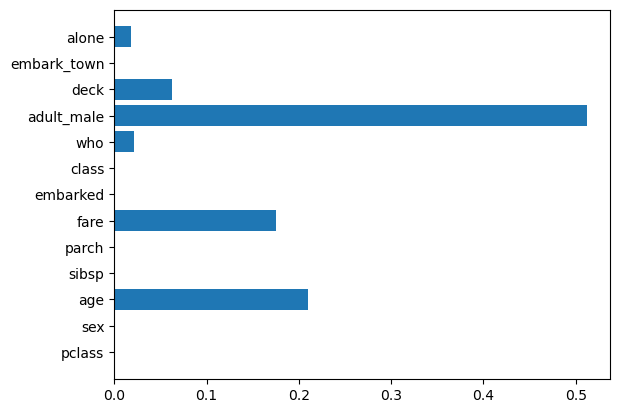

In [8]:
# 重要度可視化
plt.barh(xgb.feature_names_in_, xgb.feature_importances_)

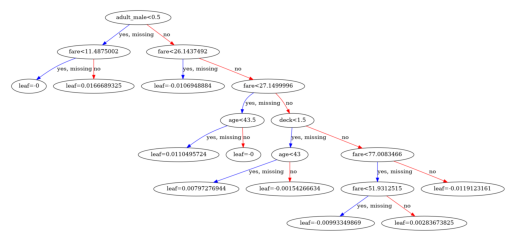

In [9]:
# 弱学習器の木の可視化
import xgboost
xgboost.plot_tree(xgb, num_trees=1)
plt.show()

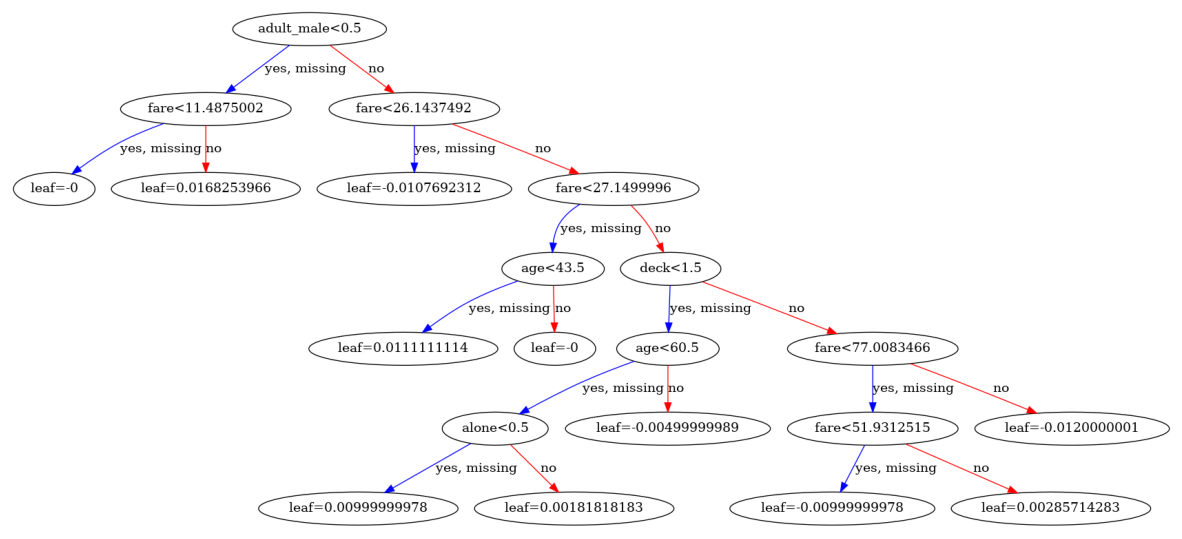

In [10]:
# グラフを大きくする
# 弱学習器の木の可視化
fig, ax = plt.subplots(figsize=(15, 10))  # グラフのサイズを指定 (幅15インチ、高さ10インチ)
xgboost.plot_tree(xgb, num_trees=0, ax=ax)
plt.show()

## LightGBM

LightGBM
- lightgbmのパッケージをインストール
    - pip install lightgbm
- lightgbm.LBMClasifier
    - n_estimators: イテレーションの回数（弱学習器の数)
    - learning_rate: 学習率のパラメータη
    - boosting_type: ブースティングアルゴリズム決定
        - 'gbdt', 'dart', 'goss', 'rf'から選択
    - max_depth: 決定木の最大深さ
- .fit(X,y)で学習
    - eval_set: 各イテレーションごとに評価したいデータ　　
        - 例: [(X_val, y_val)]
    - callbacks: 各イテレーション時に実行する関数のリスト(early stoppingに使用)
- predict(X)で予測
- lgb.plot_mtric(model)で学習曲線を描画
- lgb.plot_tree(modeｌ, tree_index）で任意の木構造を描画
    - graphizを事前にインストールする

In [11]:
import lightgbm as lgb
lgbmc = lgb.LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)

# early stoppingに使用する検証データ
eval_set = [(X_test, y_test)]

# イテレーション時に実施(callback)する関数
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=10))
callbacks.append(lgb.log_evaluation())

# 学習
lgbmc.fit(X_train, y_train, eval_set=eval_set, callbacks=callbacks)

[1]	valid_0's binary_logloss: 0.56902
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.536293
[3]	valid_0's binary_logloss: 0.50876
[4]	valid_0's binary_logloss: 0.485108
[5]	valid_0's binary_logloss: 0.464864
[6]	valid_0's binary_logloss: 0.447251
[7]	valid_0's binary_logloss: 0.433086
[8]	valid_0's binary_logloss: 0.41859
[9]	valid_0's binary_logloss: 0.408127
[10]	valid_0's binary_logloss: 0.400311
[11]	valid_0's binary_logloss: 0.400311
[12]	valid_0's binary_logloss: 0.400311
[13]	valid_0's binary_logloss: 0.400311
[14]	valid_0's binary_logloss: 0.400311
[15]	valid_0's binary_logloss: 0.400311
[16]	valid_0's binary_logloss: 0.400311
[17]	valid_0's binary_logloss: 0.400311
[18]	valid_0's binary_logloss: 0.400311
[19]	valid_0's binary_logloss: 0.400311
[20]	valid_0's binary_logloss: 0.400311
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.400311


LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)

In [12]:
y_pred_lgbmc = lgbmc.predict_proba(X_test)
print(f'lightGBM AUC: {roc_auc_score(y_test, y_pred_lgbmc[:, 1])}')

lightGBM AUC: 0.9383012820512822


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

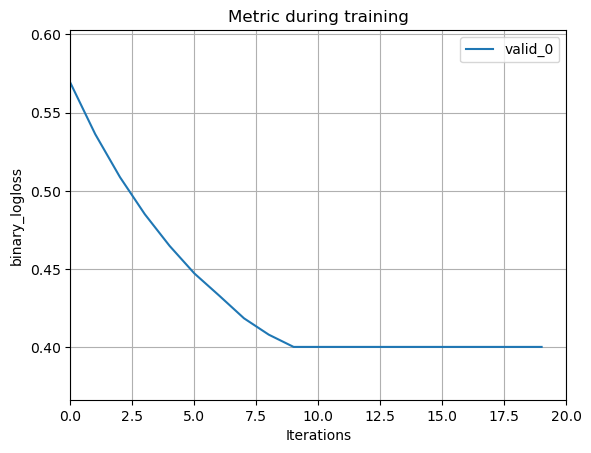

In [13]:
# 学習曲線: イテレーションの数を増加させていった際のlogloss(精度)の曲線
lgb.plot_metric(lgbmc)

<AxesSubplot:>

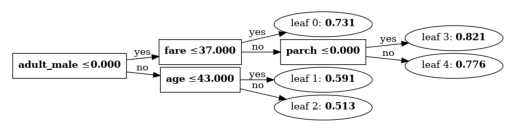

In [14]:
lgb.plot_tree(lgbmc, tree_index=0)

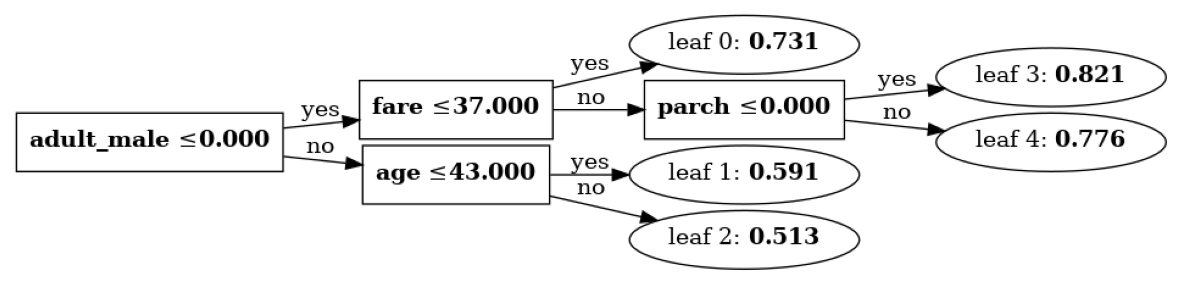

In [15]:
# グラフを大きくする
fig, ax = plt.subplots(figsize=(15, 10))  # グラフのサイズを指定 (幅15インチ、高さ10インチ)
lgb.plot_tree(lgbmc, tree_index=0, ax=ax)
plt.show()

## CatBoost

CatBoost
- catboostのパッケージをインストール
    - pip install catboost
- catboost.CatBoostClassifierクラス
    - n_estimators: イテレーションの回数（弱学習器の数)
    - learning_rate: 学習率のパラメータη
    - cat_features: カテゴリカル変数のカラム名(or index)のリスト
- .fit(X,y)で学習
    - eval_set: 各イテレーションごとに評価したいデータ　　
        - 例: [(X_val, y_val)]
    - early_stopping_rounds: early stoppingする際の最低限のイテレーション
- predict(X)で予測
- .plot_tree(tree_index)で任意の木構造を描画
    - graphizを事前にインストールする(apt-get install graphizおよび、pip install graphiz)

In [16]:
# データ準備
# titanicのデータを使うが、CatBoostはラベルエンコーディングが不要
df = sns.load_dataset('titanic')

# 欠損値削除
df.dropna(inplace=True)

# X,y生成
X = df.loc[:, (df.columns!='survived') & (df.columns!='alive')]
y = df['survived']

# カテゴリのカラム
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()

# 学習/テストデータ分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [17]:
from catboost import CatBoostClassifier
cbc = CatBoostClassifier(iterations=1000, learning_rate=0.01, cat_features=cat_cols)
eval_set = [(X_test, y_test)]
# 学習
cbc.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=10, verbose=True)

0:	learn: 0.6885366	test: 0.6868442	best: 0.6868442 (0)	total: 67.2ms	remaining: 1m 7s
1:	learn: 0.6814490	test: 0.6793775	best: 0.6793775 (1)	total: 77.2ms	remaining: 38.5s
2:	learn: 0.6760508	test: 0.6726860	best: 0.6726860 (2)	total: 80.2ms	remaining: 26.7s
3:	learn: 0.6712676	test: 0.6671826	best: 0.6671826 (3)	total: 82.4ms	remaining: 20.5s
4:	learn: 0.6653107	test: 0.6593995	best: 0.6593995 (4)	total: 85.2ms	remaining: 17s
5:	learn: 0.6598695	test: 0.6518437	best: 0.6518437 (5)	total: 87ms	remaining: 14.4s
6:	learn: 0.6558456	test: 0.6467404	best: 0.6467404 (6)	total: 88.7ms	remaining: 12.6s
7:	learn: 0.6515199	test: 0.6413944	best: 0.6413944 (7)	total: 90.7ms	remaining: 11.2s
8:	learn: 0.6471426	test: 0.6356173	best: 0.6356173 (8)	total: 92.9ms	remaining: 10.2s
9:	learn: 0.6431772	test: 0.6310513	best: 0.6310513 (9)	total: 94.7ms	remaining: 9.38s
10:	learn: 0.6392733	test: 0.6260433	best: 0.6260433 (10)	total: 96.5ms	remaining: 8.68s
11:	learn: 0.6349835	test: 0.6211657	best: 0.

In [18]:
# 予測スコア
y_pred_cbc = cbc.predict_proba(X_test)
print(f'CatBoost AUC: {roc_auc_score(y_test, y_pred_cbc[:, 1])}')

CatBoost AUC: 0.8942307692307693


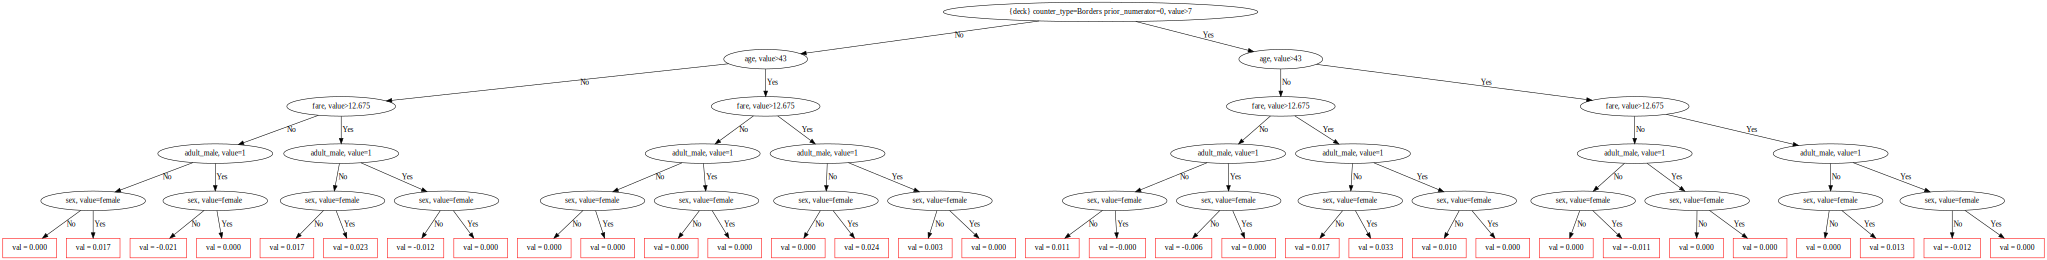

In [19]:
# 弱学習器の木構造を描画
# CatBoostだとカテゴリのカラムがindexで表示されてしまうので、下記のようにPoolを使って可視化する
from catboost import Pool
pool = Pool(X_train, y_train, cat_features=cat_cols)
cbc.plot_tree(tree_idx=1, pool=pool)